# Performance of n-step Sarsa

This notebook reproduces (mostly) and extends Figure 7.2 in the Sutton and Barto RL textbook.
Note that I use n-step Sarsa, an on-policy algorithm that learns Q values, as opposed to 
the off-policy TD algorithm for learning value functions in the text. The results are qualitatively
similar.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)
import sys

# These are my own modules
sys.path.append('..')
from agents import NstepSarsa, value_iteration, v_to_q
from envs import LinearEnv

## Running the simulations

Above I imported my implementations of n-step Sarsa and the
linear random walk environment described in the text.
Following the text, I run the algorithm with a variety of
learning rates $\alpha$ and backup lengths $n$. For each
run, I compute root mean square error compared to the true Q
function found by value iteration. Unlike the text, I also
vary the number of states in the environment.

In [3]:
def rms_error(x, y):
    return ((x - y) ** 2).mean() ** 0.5

def get_error_func(n_state, n_ep=10):
    env = LinearEnv(n_state, penalty=-1, slip=0.5)
    V = value_iteration(env, discount=.99999)
    Q = v_to_q(env, V)
    def error(nstep, learn_rate):
        agent = NstepSarsa(env, nstep=nstep, learn_rate=learn_rate)
        agent.run_many(n_ep)
        return rms_error(agent.Q, Q)
    return error

def data():
    for n_state in range(5, 26, 2):
        error = get_error_func(n_state)
        for n_sample in range(100):  # reduce variance with more samples
            for n_step in (1, 2, 4, 8, 16):
                for learn_rate in np.linspace(0.1, 1, 30):
                    yield {'n_state': n_state,
                           'n_step': n_step,
                           'learn_rate': learn_rate,
                           'error': error(n_step, learn_rate)}

try:
    # Load saved results.
    df = pd.read_pickle('pickles/fig72')
except:
    print('Running simulations...come back in an hour.')
    df = pd.DataFrame(data())
    df.to_pickle('pickles/fig72')

## Plots

The first plot reproduces Figure 7.2. If you are running this notebook locally,
you can use the slider to change
the number of states. Note that jointly optimizing learn rate and n-step
(i.e. choosing the lowest point of any curve) results in a higher n-step
as the number of states increases.


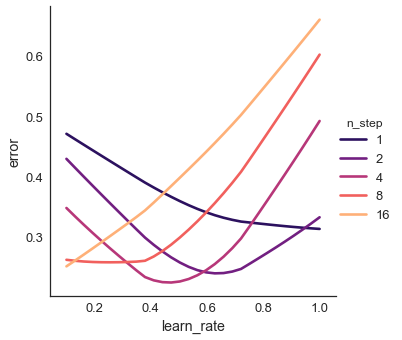

In [4]:
from ipywidgets import widgets
from ipywidgets import interact
@interact(n_state=widgets.IntSlider(min=5, max=25,step=2,value=19))
def plot_one_n_state(n_state):
    sns.lmplot('learn_rate', 'error', hue='n_step', lowess=True, 
               data=df.ix[df.n_state == n_state],
               scatter=False, palette='magma')

We can better see the relationship between learning rate, n-step, and the environment size
in the following plot, showing the optimal learning rate for each n-step and environment size.

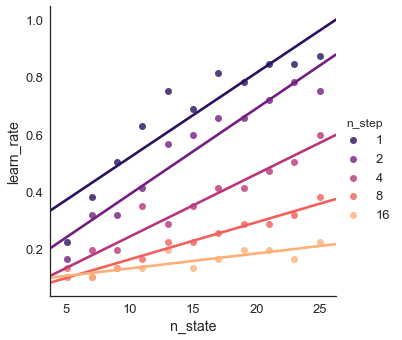

In [5]:
tbl = pd.pivot_table(df, values='error', index='learn_rate', 
               columns=['n_state', 'n_step'])
optimal = (
    tbl.apply(lambda x: x.argmin(), axis=0)
    .to_frame('learn_rate').reset_index()
)
sns.lmplot('n_state', 'learn_rate', hue='n_step', data=optimal, ci=None,
           palette='magma')

Learning rate appears to increase roughly linearly with log(n-step) and n-state.
There may be an interaction as well (especially noticable for higher n-step). We
confirm these trends with the regression below.

In [6]:
import statsmodels.formula.api as smf
from numpy import log
smf.ols('learn_rate ~ n_state * log(n_step)', data=optimal).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             learn_rate   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     289.6
Date:                Mon, 10 Apr 2017   Prob (F-statistic):           5.23e-32
Time:                        10:42:43   Log-Likelihood:                 79.691
No. Observations:                  55   AIC:                            -151.4
Df Residuals:                      51   BIC:                            -143.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1584      0.035      4.466      0.000       0.087       0.230
n_state                 0.0331      0.002     15.201      0.000       0.029       0.037
log(n_step)            -0.0500      0.021     -2.392      0.021      -0.092      -0.008
n_state:log(n_step)    -0.0095      0.001     -7.406      0.000      -0.012      -0.007
==============================================================================
Omnibus:                        1.435   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                1.177
Skew:                           0.356   Prob(JB):                        0.555
Kurtosis:                       2.921   Cond. No.                         155.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""